# Sentinel-2 Image Download and Processing

The notebook presents (1) an initial exploration of the informal settlements data in Northern Colombia and (2) procedures to download, explore, and combine multiband Sentinel 2 granules using Rasterio.

### About Informal Settlement Dataset
The Informal Settlement Dataset was received from iMMAP on March 5, 2020. The dataset contains ground-validated locations of informal migrant settlements in Northern Colombia.

### About Sentinel-2 Imagery

SENTINEL-2 is a wide-swath, high-resolution, multi-spectral imaging mission, supporting Copernicus Land Monitoring studies, including the monitoring of vegetation, soil and water cover, as well as observation of inland waterways and coastal areas ([Source](https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi/overview)). Sentinel-2 consists of 2 satellites:
- Sentinel 2A, launched in 2015
- Sentinel 2b, launched in 2017

The SENTINEL-2 Multispectral Instrument (MSI) samples 13 spectral bands: four bands at 10 metres, six bands at 20 metres and three bands at 60 metres spatial resolution.


Band | Resolution | Central Wavelength | Description
---  | ---        | ---                | ---
B1|60 m | 443 nm | Ultra blue (Coastal and Aerosol)
B2|10 m |490 nm | Blue
B3|10 m|560 nm|Green
B4|10 m|665 nm|Red
B5|20 m|705 nm|Visible and Near Infrared (VNIR)
B6|20 m|740 nm|Visible and Near Infrared (VNIR)
B7|20 m|783 nm|Visible and Near Infrared (VNIR)
B8|10 m|842 nm|Visible and Near Infrared (VNIR)
B8a|20 m|865 nm|Visible and Near Infrared (VNIR)
B9|60 m|940 nm|Short Wave Infrared (SWIR)
B10|60 m|1375 nm|Short Wave Infrared (SWIR)
B11|20 m|1610 nm|Short Wave Infrared (SWIR)
B12|20 m|2190 nm|Short Wave Infrared (SWIR)

### Sentinel-2 Products: Level-1C and Level-2A

The following two main Sentinel-2 products are generated by the mission ([source](https://en.wikipedia.org/wiki/Sentinel-2)):

- <b>Level-1C</b>: Top-of-atmosphere reflectances in cartographic geometry (combined UTM projection and WGS84 ellipsoid). Level-1C products are tiles of 100 km2 each one with a volume of approximately 500 MB. These products are radiometrically and geometrically corrected (including orthorectification). This product can be obtained from the [Copernicus Open Access Hub](https://scihub.copernicus.eu/).

- <b>Level-2A</b>: Surface reflectances in cartographic geometry. This product is considered as the mission Analysis Ready Data (ARD), the product that can be used directly in downstream applications without the need for further processing. This product can be obtained either from the [Copernicus Open Access Hub](https://scihub.copernicus.eu/) or generated by the user with the [sen2cor processor](http://step.esa.int/main/third-party-plugins-2/sen2cor/sen2cor_v2-8/).

### References
- [Copernicus Open Access Hub](https://scihub.copernicus.eu/) 
- [Sentinel-2 Bands and Combinations](https://gisgeography.com/sentinel-2-bands-combinations/)
- [Sentinel Hub Playground](https://apps.sentinel-hub.com/sentinel-playground/)
- [Sentinel2 images exploration and processing with Python and Rasterio](https://www.hatarilabs.com/ih-en/sentinel2-images-explotarion-and-processing-with-python-and-rasterio)
- [Accessing Free Satellite imagery via GCP Public Datasets](https://oshean.netlify.com/blog/3-eeandbq/)

## Imports and Setup
In your terminal, install nodejs:
```sh
conda install nodejs
```

In [2]:
# Uncomment the following to install:
#!pip install geopandas -q
#!pip install rasterio -q
#!pip install sentinelsat -q
#!pip install six==1.13.0 -q
#!pip install google-cloud-bigquery==1.23.0 -q
#!pip install pandas-profiling -q
#!jupyter nbextension enable --py widgetsnbextension
#!jupyter labextension install @jupyter-widgets/jupyterlab-manager

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK
Building jupyterlab assets (build:prod:minimize)


In [1]:
import os
import pandas as pd
import pandas_profiling
import geopandas as gpd
import rasterio as rio
from rasterio import plot
pd.set_option('display.max_colwidth', -1)

import logging
import warnings
logging.getLogger().setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline

## File Locations

In [2]:
data_dir = "../data/"
sentinel_dir = data_dir + 'Sentinel2/'

if not os.path.exists(data_dir):
    os.makedirs(data_dir)
if not os.path.exists(sentinel_dir):
    os.makedirs(sentinel_dir)

download_file = sentinel_dir + 'download.csv'

## Load Data

In [3]:
ground_truth = gpd.read_file('../data/Settlements/Settlements_WASH_UNICEF.shp')
ground_truth.head(2)

,y,x,tipo_lugar,tipo_estab,estado,nombre_sit,nombre_alt,Departamen,Municipio,_ubicacion,tipo_ubica,geometry
0,11.373327,-72.267074,Asentamiento,Asentamiento,Abierto y activo,Invasión arroyo las américas,None,La Guajira,Maicao,4.0,Periurbano,POINT (-72.26707 11.37333)
1,11.373402,-72.267809,Asentamiento,Asentamiento,Abierto y activo,Colopontain cerca del arroyo las américas,None,La Guajira,Maicao,3.0,Periurbano,POINT (-72.26781 11.37340)


## Pandas Profiling

In [4]:
pandas_profiling.ProfileReport(ground_truth.iloc[:, :-1])

## Download Sentinel-2 Imagery

This section provides scripts for downloading Sentinel-2 images. You may opt to use the [Copernicus Open Access Hub](https://scihub.copernicus.eu/dhus/#/home) to explore and select your preferred images. 

- For 2017 imagery, we access Sentinel-2 images via the [GCP Public Dataset](https://oshean.netlify.com/blog/3-eeandbq/).
- For 2019 imagery, we access Sentinel-2 images via the [Sentinelsat API](https://sentinelsat.readthedocs.io/en/stable/api.html). 

### GCP Public Dataset (2017 Imagery)
The scripts in this section are based on [this amazing tutorial by Oshean Garonita](https://oshean.netlify.com/blog/3-eeandbq/). GCP Public Dataset is used when the product is _offline and inaccessible_ via the Copernicus Open Access Hub.

In [26]:
from google.cloud import bigquery

client = bigquery.Client(location="US")
print("Client creating using default project: {}".format(client.project))

query = """
    SELECT
        *
    FROM
        `bigquery-public-data.cloud_storage_geo_index.sentinel_2_index`
    WHERE 
        product_id in (
            'S2A_MSIL1C_20170104T152622_N0204_R025_T18PYT_20170104T152625',
            'S2A_MSIL1C_20170723T152641_N0205_R025_T18PYT_20170723T152915',
            'S2A_MSIL1C_20180320T152641_N0206_R025_T18PYT_20180320T184953'
        )
"""

query_job = client.query(
    query,
    location="US",
)
query = query_job.to_dataframe()
query['base_url'].to_csv(download_file, index=False)
query.head()

Client creating using default project: immap-colombia-270609


,granule_id,product_id,datatake_identifier,mgrs_tile,sensing_time,geometric_quality_flag,generation_time,north_lat,south_lat,west_lon,east_lon,base_url,total_size,cloud_cover
0,L1C_T18PYT_A014322_20180320T152636,S2A_MSIL1C_20180320T152641_N0206_R025_T18PYT_20180320T184953,GS2A_20180320T152641_014322_N02.06,18PYT,2018-03-20T15:26:36.460000Z,None,2018-03-20T18:49:53.000000Z,11.754234,10.754195,-73.171434,-72.158289,gs://gcp-public-data-sentinel-2/tiles/18/P/YT/S2A_MSIL1C_20180320T152641_N0206_R025_T18PYT_20180320T184953.SAFE,825902225,0.0104
1,L1C_T18PYT_A010890_20170723T152915,S2A_MSIL1C_20170723T152641_N0205_R025_T18PYT_20170723T152915,GS2A_20170723T152641_010890_N02.05,18PYT,2017-07-23T15:29:15.600000Z,PASSED,2017-07-23T15:29:15.000000Z,11.754234,10.754195,-73.171434,-72.158289,gs://gcp-public-data-sentinel-2/tiles/18/P/YT/S2A_MSIL1C_20170723T152641_N0205_R025_T18PYT_20170723T152915.SAFE,846361534,8.5965
2,L1C_T18PYT_A008030_20170104T152625,S2A_MSIL1C_20170104T152622_N0204_R025_T18PYT_20170104T152625,GS2A_20170104T152622_008030_N02.04,18PYT,2017-01-04T15:26:25.462000Z,PASSED,2017-01-04T15:26:25.000000Z,11.754234,10.754195,-73.171434,-72.158289,gs://gcp-public-data-sentinel-2/tiles/18/P/YT/S2A_MSIL1C_20170104T152622_N0204_R025_T18PYT_20170104T152625.SAFE,832769422,4.4341


Using Google Cloud SDK, we can download the images directly as follows.

In [23]:
!cat {download_file} | gsutil -q -m cp -r -I {sentinel_dir} 
!rm -r {download_file}

### Sentinelsat API (2019 Imagery)

The [Sentinelsat API](https://sentinelsat.readthedocs.io/en/stable/api.html) directly downloads data from the [Copernicus Open Access Hub](https://scihub.copernicus.eu/dhus/). Note that you are required to register in order to access the images using your account username and password.

In [27]:
from sentinelsat.sentinel import SentinelAPI
from datetime import date

api = SentinelAPI('<username>', '<password>', 'https://scihub.copernicus.eu/dhus')

product_ids = [
    '8147a118-4780-4f54-8204-9ad67135a74a',
    '18b02436-2ddc-4e05-ae14-9fc69f925428',
    'f9200aec-5dc7-412d-9885-2039a0b0ee3b'
]
products = []
for product_id in product_ids:
    products.append(api.get_product_odata(product_id, full=True))
products = pd.DataFrame(products)
products[['id', 'title', 'Cloud cover percentage', 'Date', 'Sensing start', 'Sensing stop']].sort_values('Date').head()

,id,title,Cloud cover percentage,Date,Sensing start,Sensing stop
2,f9200aec-5dc7-412d-9885-2039a0b0ee3b,S2A_MSIL2A_20181225T152631_N0211_R025_T18PYT_20181225T174326,0.520960,2018-12-25 15:26:31.024,2018-12-25 15:26:31.024,2018-12-25 15:26:31.024
1,18b02436-2ddc-4e05-ae14-9fc69f925428,S2A_MSIL2A_20190325T152641_N0211_R025_T18PYT_20190325T211142,0.416578,2019-03-25 15:26:41.024,2019-03-25 15:26:41.024,2019-03-25 15:26:41.024
0,8147a118-4780-4f54-8204-9ad67135a74a,S2A_MSIL2A_20190703T152641_N0212_R025_T18PYT_20190703T211344,0.569364,2019-07-03 15:26:41.024,2019-07-03 15:26:41.024,2019-07-03 15:26:41.024


In [25]:
for product_id in product_ids:
    api.download(product_id, directory_path=sentinel_dir);

Downloading: 100%|██████████| 1.16G/1.16G [00:50<00:00, 23.0MB/s]
MD5 checksumming: 100%|██████████| 1.16G/1.16G [00:02<00:00, 411MB/s]


In [28]:
zip_files = [
    sentinel_dir + 'S2A_MSIL2A_20181225T152631_N0211_R025_T18PYT_20181225T174326.zip',
    sentinel_dir + 'S2A_MSIL2A_20190325T152641_N0211_R025_T18PYT_20190325T211142.zip',
    sentinel_dir + 'S2A_MSIL2A_20190703T152641_N0212_R025_T18PYT_20190703T211344.zip'
]
for zip_file in zip_files:
    !unzip -q {zip_file} -d {sentinel_dir}
    !rm -r {zip_file}

## Combining Sentinel-2 Bands

Band combinations can be used to better understand the features in imagery. By using band combinations, we can extract specific information, e.g. band combinations that highlight geologic, agricultural or vegetation features in an image. To see Sentinel band combinations, check out the [Sentinel Hub Playground](https://apps.sentinel-hub.com/sentinel-playground/), which visualizes several band combinations.

In [6]:
def combine_bands(
    image_name,
    band_files,
    suffix='RGB',
    plot=True
):
    bands = []
    for band_file in band_files:
        band = rio.open(band_file, driver='JP2OpenJPEG') 
        bands.append(band)
    
    if plot is True:
        fig, ax = plt.subplots(1, len(bands), figsize=(12, 4))
        cmaps = ['Reds', 'Greens', 'Blues']
        for index, (band, cmap) in enumerate(zip(bands, cmaps[:len(bands)])):
            rio.plot.show(band, ax=ax[index], cmap=cmap)
        fig.tight_layout()

    image_file = '{}{}_{}.tiff'.format(
        sentinel_dir, image_name, suffix
    )
    image = rio.open(
        image_file, 
        'w',
        driver='Gtiff',
        count=3,
        width=bands[0].width,
        height=bands[0].height,
        crs=bands[0].crs,
        dtype=bands[0].dtypes[0],
        transform=bands[0].transform,
    )
    for index, band in enumerate(bands):
        image.write(band.read(1), index+1)
    image.close()

### 20181225 Sentinel-2 MSI L2A: Natural Color (B4, B3, B2)

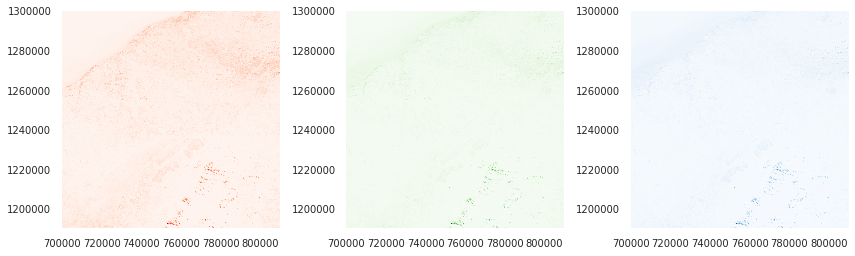

In [32]:
image_name = 'S2A_MSIL2A_20181225T152631_N0211_R025_T18PYT_20181225T174326'
image_path = sentinel_dir + '{}.SAFE/GRANULE/L2A_T18PYT_A018326_20181225T152632/IMG_DATA/R10m/'.format(image_name)
band_files = [image_path+'T18PYT_20181225T152631_B0{}_10m.jp2'.format(x) for x in [4, 3, 2]]

combine_bands(image_name, band_files, suffix='RGB')

### 201900325 Sentinel-2 MSI L2A: Natural Color (B4, B3, B2)

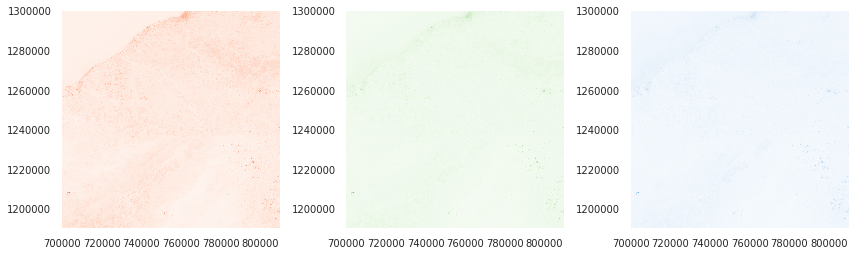

In [29]:
image_name = 'S2A_MSIL2A_20190325T152641_N0211_R025_T18PYT_20190325T211142'
image_path = sentinel_dir + '{}.SAFE/GRANULE/L2A_T18PYT_A019613_20190325T152920/IMG_DATA/R10m/'.format(image_name)
band_files = [image_path+'T18PYT_20190325T152641_B0{}_10m.jp2'.format(x) for x in [4, 3, 2]]

combine_bands(image_name, band_files, suffix='RGB')

### 20190703 Sentinel-2 MSI L2A: Natural Color (B4, B3, B2)

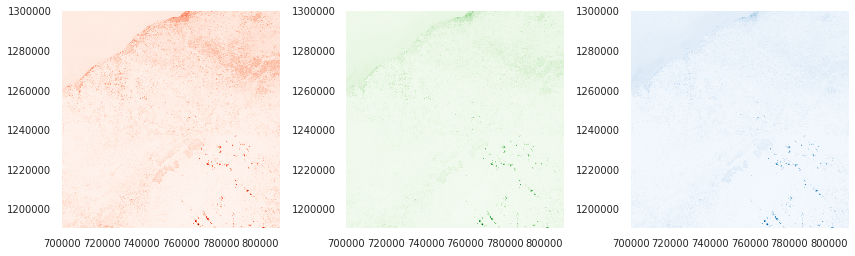

In [31]:
image_name = 'S2A_MSIL2A_20190703T152641_N0212_R025_T18PYT_20190703T211344'
image_path = sentinel_dir + '{}.SAFE/GRANULE/L2A_T18PYT_A021043_20190703T152742/IMG_DATA/R10m/'.format(image_name)
band_files = [image_path+'T18PYT_20190703T152641_B0{}_10m.jp2'.format(x) for x in [4, 3, 2]]

combine_bands(image_name, band_files, suffix='RGB')

### 20190703 Sentinel-2 MSI L2A: Short-Wave Infrared (B12, B8A, B4)

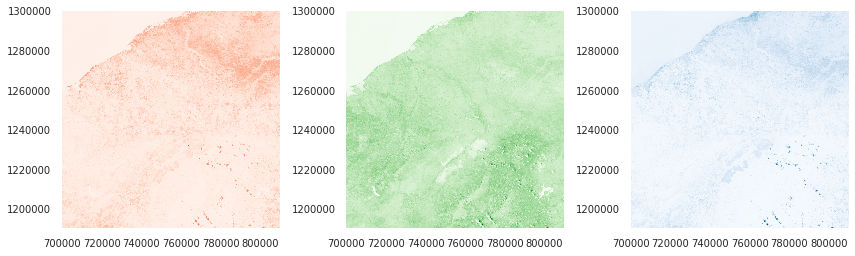

In [30]:
image_name = 'S2A_MSIL2A_20190703T152641_N0212_R025_T18PYT_20190703T211344'
image_path = sentinel_dir + '{}.SAFE/GRANULE/L2A_T18PYT_A021043_20190703T152742/IMG_DATA/R20m/'.format(image_name)
band_files = [image_path+'T18PYT_20190703T152641_B{}_20m.jp2'.format(x) for x in [12, '8A', '04']]

combine_bands(image_name, band_files, suffix='SWIR')

### Sentinel-2 Level 2A Generation
Level-2A generation can be performed by the user through the Sentinel-2 Toolbox using as input the associated Level-1C product ([source](https://earth.esa.int/web/sentinel/user-guides/sentinel-2-msi/product-types/level-2a)). You can [download the Sentinel-2 Toolbox Sen2Cor here](http://step.esa.int/main/third-party-plugins-2/sen2cor/sen2cor_v2-8/).

Installing Sen2Cor-2.08.00:
```sh
mkdir sen2cor
cd sen2cor
wget http://step.esa.int/thirdparties/sen2cor/2.8.0/Sen2Cor-02.08.00-Linux64.run
chmod +x Sen2Cor-02.08.00-Linux64.run
./Sen2Cor-02.08.00-Linux64.run
```

After installation, run:
```sh
/home/<user>/sen2cor/Sen2Cor-02.08.00-Linux64/bin/L2A_Process --GIP_L2A /home/<user>/sen2cor/2.8/cfg/L2A_GIPP.xml <path to Sentinel-2 L1C product>
```

If you run into the error 
```
AttributeError: 'bool' object has no attribute 'SPACECRAFT_NAME'
```
Simply create empty directories called `AUX_DATA` and `DATASTRIP/DS_MTI*/QI_DATA` in your Sentinel-2 product directory ([source](https://forum.step.esa.int/t/sen2cor-2-8-fails-on-product-from-early-2016-bool-object-has-no-attribute-spacecraft-name/16046)).

[More information on Sen2Cor-2.08.00 here](http://step.esa.int/thirdparties/sen2cor/2.8.0/docs/S2-PDGS-MPC-L2A-SUM-V2.8.pdf).

### 20170104 Sentinel-2 MSI L2A: Natural Color (B4, B3, B2)

In [ ]:
image_name = 'S2A_MSIL2A_20170104T152622_N9999_R025_T18PYT_20200311T125324'
image_path = sentinel_dir + '{}.SAFE/GRANULE/L2A_T18PYT_A008030_20170104T152625/IMG_DATA/R10m/'.format(image_name)
band_files = [image_path+'T18PYT_20170104T152622_B0{}_10m.jp2'.format(x) for x in [4, 3, 2]]

combine_bands(image_name, band_files, suffix='RGB', plot=False)

### 20170104 Sentinel-2 MSI L2A: Short-Wave Infrared (B12, B8A, B4)

In [ ]:
image_name = 'S2A_MSIL2A_20170104T152622_N9999_R025_T18PYT_20200311T125324'
image_path = sentinel_dir + '{}.SAFE/GRANULE/L2A_T18PYT_A008030_20170104T152625/IMG_DATA/R10m/'.format(image_name)
band_files = [image_path+'T18PYT_20170104T152622_B{}_10m.jp2'.format(x) for x in [12, '8A', '04']]

combine_bands(image_name, band_files, suffix='SWIR', plot=False)